In [10]:
import numpy as np 
import matplotlib.pyplot as plt

In [32]:
class YieldFunction():
    def __init__(self, name, mode, function, num_args, range): 
        self.name = name
        self.mode = mode
        # assumed now that the function can successfully be applied on numpy arrays. 
        # can modify code to be generalized to all types of functions
        self.function = function
        
        self.num_args = num_args
        self.range = range
    def return_yield(self, values): 
        
        if self.num_args == 1: 
            return self.function(values)
        elif self.num_args == 2: 
            # this assumes that the values are stored as a n by 2 numpy array 
            return self.function(values[:, 0], values[:, 1])
        else:
            raise AssertionError("return_yield, not yet implemented >2 dimensional")
    def plot_function(self):
        if self.num_args == 1:
            total_values = np.linspace(self.range[0], self.range[1])
            plt.plot(total_values, self.return_yield(total_values))
            plt.title(f"Yield over range for {self.name}")
            plt.ylabel("Yields")
            plt.xlabel(f"{self.mode} values across range")

9


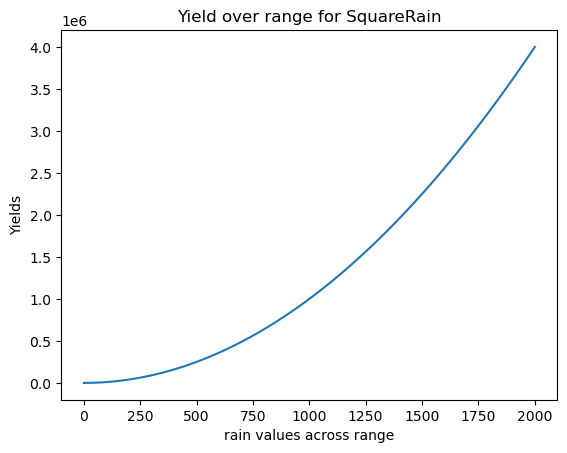

In [33]:
test = YieldFunction(name = "SquareRain", mode = "rain", function = np.square, num_args = 1, range = [1,2000])
print(test.return_yield(3))
test.plot_function()

In [42]:
# Great! Now we should define some yield functions that we can just use 
growing_rain_yield_functions = []
def flat_grow_rain(sum_rain):
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [600, 1000])
    # if sum_rain <= 800: 
    #     return 600
    # else:
    #     return 1000
def single_thresh_grow_rain(sum_rain):
    alpha = 0.5 
    # if sum_rain >= 800:
    #     return 1000
    # else:
    #     return 1000 - alpha * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain < 800, sum_rain >= 800], [lambda x: 1000 - alpha * (800 - x), 1000])
def double_kink_grow_rain(sum_rain):
    alpha = 0.5 
    beta = 1.0
    # if sum_rain >= 800:
    #     return 1000
    # elif sum_rain >= 650:
    #     return 1000 - alpha * (800 - sum_rain)
    # else: 
    #     return 1000 - beta * (800 - sum_rain)
    return np.piecewise(sum_rain, [sum_rain >= 800, sum_rain >= 650, sum_rain < 650], [1000, lambda x: 1000 - alpha * (800 - x), lambda x: 1000 - beta * (800 - x)])

def quad_grow_rain(sum_rain):
    alpha = 0.00155
    beta = 800
    gamma = 1000
    return - (alpha * (sum_rain - beta)**2) + gamma

In [54]:
flat_rain = YieldFunction(name = "FlatRain", mode = "rain", function = flat_grow_rain, num_args = 1, range = [0,1500])
single_lin_rain = YieldFunction(name = "SingleLinRain", mode = "rain", function = single_thresh_grow_rain, num_args = 1, range = [0,1500])
double_lin_rain = YieldFunction(name = "DoubleLinRain", mode = "rain", function = double_kink_grow_rain, num_args = 1, range = [0,1500])
quad_rain = YieldFunction(name = "QuadRain", mode = "rain", function = quad_grow_rain, num_args = 1, range = [0,1500])
growing_rain_yield_functions.extend([flat_rain, single_lin_rain, double_lin_rain, quad_rain])

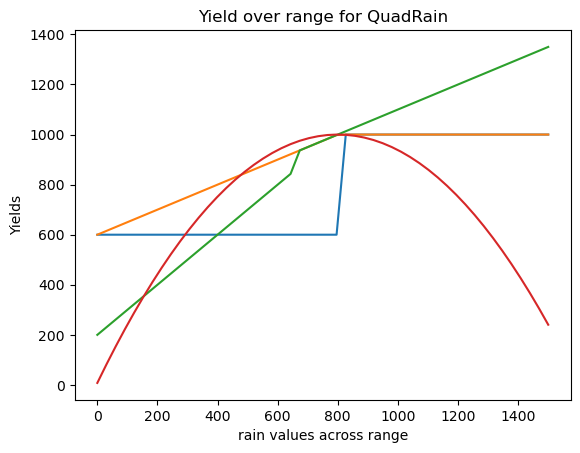

In [55]:
for _ in growing_rain_yield_functions:
    _.plot_function()

In [60]:
# now add variability
std_dev = 1
coeff_var = std_dev / pop_mean 
x = np.random.normal(0, std_dev ** 2, 10000)
total_values = np.linspace(0, 1500)
plt.plot(x)

SyntaxError: invalid syntax (2331982476.py, line 2)